# Recurrent and Recursive Neural Networks: A Comprehensive Guide

## Table of Contents
1. [Introduction and Prerequisites](#1-introduction)
2. [Understanding Sequential Data](#2-sequential-data)
3. [Unfolding Computational Graphs](#3-unfolding)
4. [Recurrent Neural Networks (RNNs)](#4-rnn)
5. [Bidirectional RNNs](#5-bidirectional)
6. [Deep Recurrent Networks](#6-deep-rnn)
7. [Long Short-Term Memory (LSTM)](#7-lstm)
8. [Gated Recurrent Units (GRUs)](#8-gru)
9. [Recursive Neural Networks](#9-recursive)
10. [Practical Implementation](#10-implementation)
11. [Applications and Best Practices](#11-applications)

## 1. Introduction and Prerequisites <a id='1-introduction'></a>

### What You'll Learn
- How RNNs process sequential data
- The architecture and mathematics behind different RNN variants
- When to use each type of network
- How to implement these networks in practice

### Prerequisites
Before diving into RNNs, let's ensure we understand the basics of neural networks.

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import torch
import torch.nn as nn

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print("Libraries loaded successfully!")

TensorFlow version: 2.17.0
PyTorch version: 2.4.0
Libraries loaded successfully!


### Quick Review: Feed-Forward Neural Networks

Traditional neural networks process fixed-size inputs and produce fixed-size outputs. They have no memory of previous inputs.

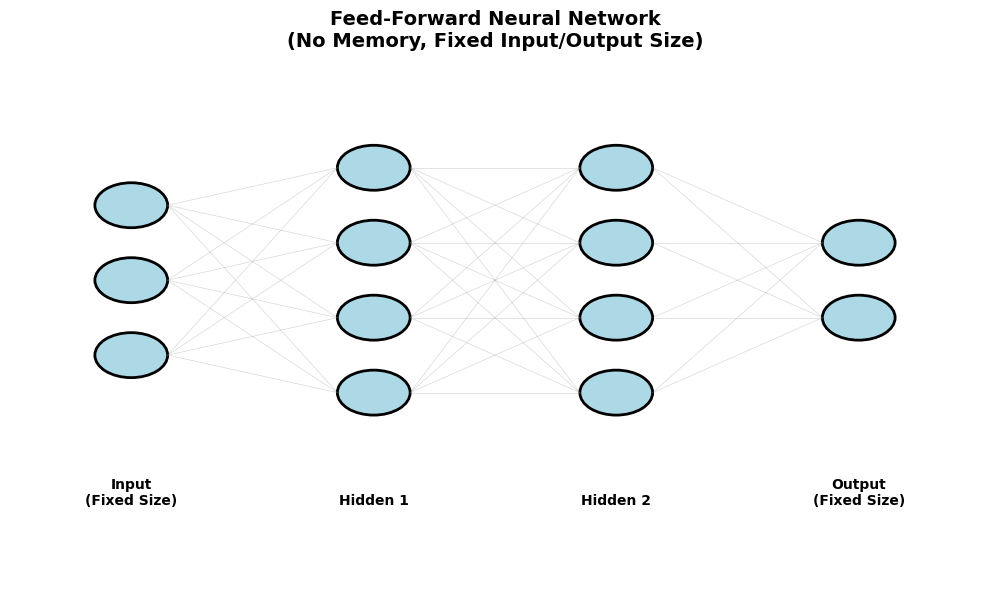

In [7]:
# Visualization of a simple feedforward network
def visualize_feedforward():
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Network structure
    layers_sizes = [3, 4, 4, 2]  # Input, Hidden1, Hidden2, Output
    layer_names = ['Input\n(Fixed Size)', 'Hidden 1', 'Hidden 2', 'Output\n(Fixed Size)']
    
    # Draw nodes
    for layer_idx, (size, name) in enumerate(zip(layers_sizes, layer_names)):
        x = layer_idx * 2
        for node_idx in range(size):
            y = (size - 1) / 2 - node_idx
            circle = plt.Circle((x, y), 0.3, color='lightblue', ec='black', linewidth=2)
            ax.add_patch(circle)
            
            # Connect to next layer
            if layer_idx < len(layers_sizes) - 1:
                next_size = layers_sizes[layer_idx + 1]
                for next_node_idx in range(next_size):
                    next_y = (next_size - 1) / 2 - next_node_idx
                    ax.plot([x + 0.3, x + 2 - 0.3], [y, next_y], 
                           'gray', alpha=0.3, linewidth=0.5)
        
        # Add layer labels
        ax.text(x, -3, name, ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xlim(-1, 7)
    ax.set_ylim(-4, 3)
    ax.axis('off')
    ax.set_title('Feed-Forward Neural Network\n(No Memory, Fixed Input/Output Size)', 
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_feedforward()

## 2. Understanding Sequential Data <a id='2-sequential-data'></a>

### Why Do We Need RNNs?

Many real-world problems involve sequential data where:
- **Order matters**: "The cat ate the mouse" vs "The mouse ate the cat"
- **Context from past is important**: Understanding current word based on previous words
- **Variable length inputs**: Sentences can have different lengths

In [8]:
# Examples of sequential data
sequential_examples = {
    "Text": ["Hello", "World", "!"],
    "Time Series": [23.5, 24.1, 24.8, 25.2, 24.9],
    "Audio": "Sequence of amplitude values over time",
    "Video": "Sequence of image frames",
    "DNA": ["A", "T", "G", "C", "C", "A", "T"]
}

print("Examples of Sequential Data:")
print("=" * 40)
for data_type, example in sequential_examples.items():
    print(f"{data_type:12} : {example}")

# Demonstrate why order matters
print("\nWhy Order Matters:")
print("=" * 40)
sentence1 = ["The", "dog", "chased", "the", "cat"]
sentence2 = ["The", "cat", "chased", "the", "dog"]
print(f"Sentence 1: {' '.join(sentence1)}")
print(f"Sentence 2: {' '.join(sentence2)}")
print("Same words, different order = Different meaning!")

Examples of Sequential Data:
Text         : ['Hello', 'World', '!']
Time Series  : [23.5, 24.1, 24.8, 25.2, 24.9]
Audio        : Sequence of amplitude values over time
Video        : Sequence of image frames
DNA          : ['A', 'T', 'G', 'C', 'C', 'A', 'T']

Why Order Matters:
Sentence 1: The dog chased the cat
Sentence 2: The cat chased the dog
Same words, different order = Different meaning!


## 3. Unfolding Computational Graphs <a id='3-unfolding'></a>

### The Concept of Unfolding

RNNs can be viewed in two ways:
1. **Rolled (Recurrent) View**: Compact representation with loops
2. **Unrolled View**: Expanded over time steps

Unfolding helps us understand how information flows through time.

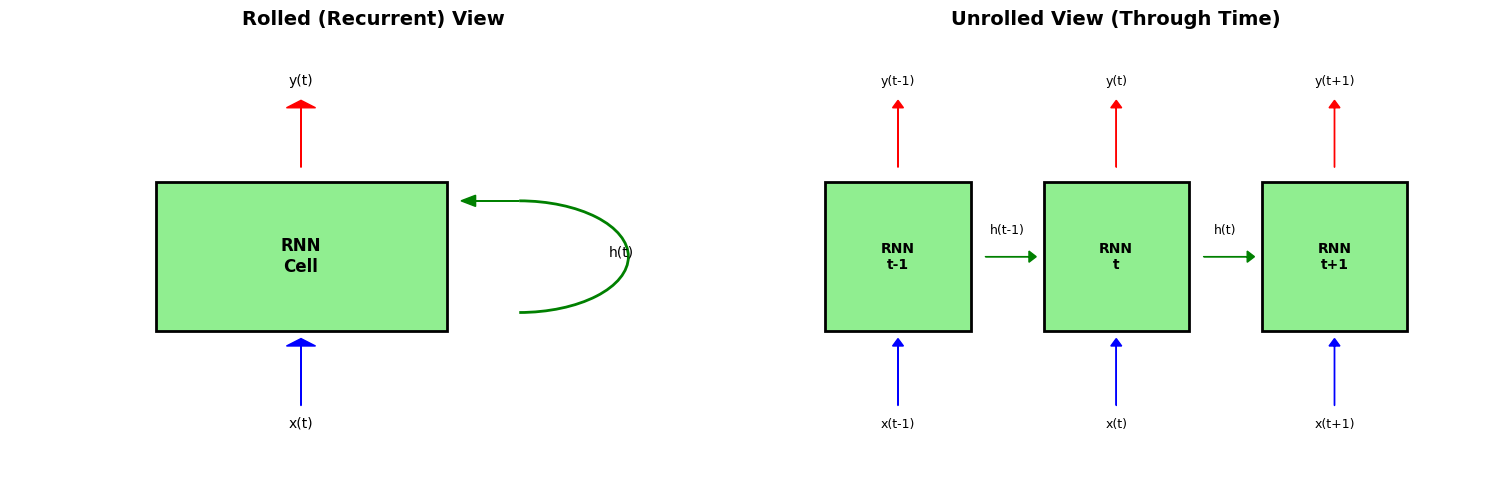

In [9]:
from matplotlib.patches import Arc

# Visualization of unfolding
def visualize_unfolding():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Rolled view
    ax1.set_title('Rolled (Recurrent) View', fontsize=14, fontweight='bold')
    
    # Draw RNN cell
    rect = plt.Rectangle((1, 1), 2, 2, fill=True, 
                         facecolor='lightgreen', edgecolor='black', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(2, 2, 'RNN\nCell', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Input arrow
    ax1.arrow(2, 0, 0, 0.8, head_width=0.2, head_length=0.1, fc='blue', ec='blue')
    ax1.text(2, -0.3, 'x(t)', ha='center', fontsize=10)
    
    # Output arrow
    ax1.arrow(2, 3.2, 0, 0.8, head_width=0.2, head_length=0.1, fc='red', ec='red')
    ax1.text(2, 4.3, 'y(t)', ha='center', fontsize=10)
    
    # Recurrent connection
    ax1.add_patch(Arc((3.5, 2), 1.5, 1.5, angle=0, theta1=-90, theta2=90,
                          edgecolor='green', linewidth=2))
    ax1.arrow(3.5, 2.75, -0.3, 0, head_width=0.15, head_length=0.1, fc='green', ec='green')
    ax1.text(4.2, 2, 'h(t)', ha='center', fontsize=10)
    
    ax1.set_xlim(0, 5)
    ax1.set_ylim(-1, 5)
    ax1.axis('off')
    
    # Unrolled view
    ax2.set_title('Unrolled View (Through Time)', fontsize=14, fontweight='bold')
    
    time_steps = ['t-1', 't', 't+1']
    for i, t in enumerate(time_steps):
        x_pos = i * 3 + 1
        
        # RNN cell
        rect = plt.Rectangle((x_pos, 1), 2, 2, fill=True,
                            facecolor='lightgreen', edgecolor='black', linewidth=2)
        ax2.add_patch(rect)
        ax2.text(x_pos + 1, 2, f'RNN\n{t}', ha='center', va='center', 
                fontsize=10, fontweight='bold')
        
        # Input
        ax2.arrow(x_pos + 1, 0, 0, 0.8, head_width=0.15, head_length=0.1, 
                 fc='blue', ec='blue')
        ax2.text(x_pos + 1, -0.3, f'x({t})', ha='center', fontsize=9)
        
        # Output
        ax2.arrow(x_pos + 1, 3.2, 0, 0.8, head_width=0.15, head_length=0.1,
                 fc='red', ec='red')
        ax2.text(x_pos + 1, 4.3, f'y({t})', ha='center', fontsize=9)
        
        # Hidden state connection
        if i < len(time_steps) - 1:
            ax2.arrow(x_pos + 2.2, 2, 0.6, 0, head_width=0.15, head_length=0.1,
                     fc='green', ec='green')
            ax2.text(x_pos + 2.5, 2.3, f'h({t})', ha='center', fontsize=9)
    
    ax2.set_xlim(0, 10)
    ax2.set_ylim(-1, 5)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_unfolding()

### Mathematical Representation of Unfolding

The key equations for an RNN cell at time step $t$:

$$h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)$$
$$y_t = W_{hy} \cdot h_t + b_y$$

Where:
- $x_t$: Input at time $t$
- $h_t$: Hidden state at time $t$
- $y_t$: Output at time $t$
- $W_{xh}, W_{hh}, W_{hy}$: Weight matrices
- $b_h, b_y$: Bias vectors

In [10]:
# Simple implementation to show unfolding mathematically
class SimpleRNNCell:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
    def forward_step(self, x, h_prev):
        """Forward pass for one time step"""
        # Update hidden state
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
        # Compute output
        y = np.dot(self.Why, h) + self.by
        return h, y
    
    def unfold(self, X):
        """Process sequence by unfolding through time"""
        T = len(X)  # Number of time steps
        hidden_states = []
        outputs = []
        
        # Initial hidden state
        h = np.zeros((self.Whh.shape[0], 1))
        
        # Unfold through time
        for t in range(T):
            h, y = self.forward_step(X[t], h)
            hidden_states.append(h)
            outputs.append(y)
            
        return hidden_states, outputs

# Example usage
rnn = SimpleRNNCell(input_size=3, hidden_size=4, output_size=2)

# Create sample sequence (5 time steps, 3 features each)
sequence = [np.random.randn(3, 1) for _ in range(5)]

# Process sequence
hidden_states, outputs = rnn.unfold(sequence)

print("Unfolding Process:")
print("=" * 40)
print(f"Input sequence length: {len(sequence)}")
print(f"Number of hidden states: {len(hidden_states)}")
print(f"Number of outputs: {len(outputs)}")
print(f"\nHidden state shape at each step: {hidden_states[0].shape}")
print(f"Output shape at each step: {outputs[0].shape}")

Unfolding Process:
Input sequence length: 5
Number of hidden states: 5
Number of outputs: 5

Hidden state shape at each step: (4, 1)
Output shape at each step: (2, 1)


## 4. Recurrent Neural Networks (RNNs) <a id='4-rnn'></a>

### Core Architecture

RNNs maintain a hidden state that acts as memory, allowing them to process sequences of arbitrary length.

In [13]:
# Detailed RNN implementation with TensorFlow/Keras
class DetailedRNN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.rnn = layers.SimpleRNN(rnn_units, return_sequences=True, return_state=True)
        self.dense = layers.Dense(vocab_size)
        
    def call(self, inputs, states=None, training=False):
        x = self.embedding(inputs)
        if states is None:
            batch_size = tf.shape(inputs)[0]
            rnn_units = self.rnn.units
            states = tf.zeros((batch_size, rnn_units), dtype=x.dtype)
        x, states = self.rnn(x, initial_state=states)
        x = self.dense(x)
        return x, states

# Example: Text generation with RNN
vocab_size = 1000
embedding_dim = 64
rnn_units = 128
batch_size = 32
seq_length = 100

# Create model
model = DetailedRNN(vocab_size, embedding_dim, rnn_units)

# Create dummy input
dummy_input = tf.random.uniform((batch_size, seq_length), 
                                minval=0, maxval=vocab_size, dtype=tf.int32)

# Forward pass
output, final_state = model(dummy_input)

print("RNN Architecture Details:")
print("=" * 40)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Final hidden state shape: {final_state[0].shape if isinstance(final_state, list) else final_state.shape}")
print(f"\nTotal parameters: {model.count_params()}")

RNN Architecture Details:
Input shape: (32, 100)
Output shape: (32, 100, 1000)
Final hidden state shape: (32, 128)

Total parameters: 217704


### Types of RNN Architectures

RNNs can be configured for different tasks:

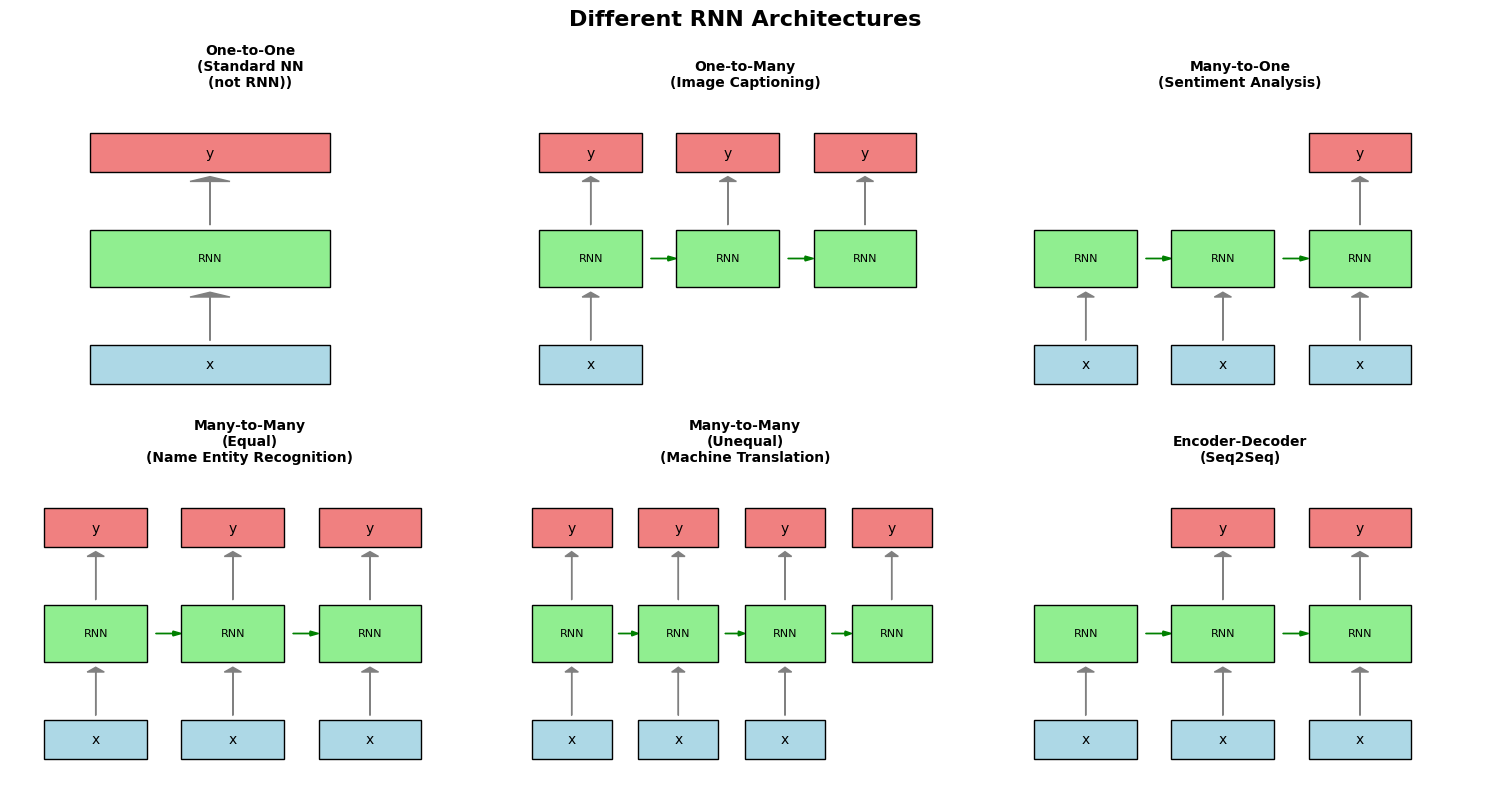

In [14]:
# Visualization of different RNN architectures
def visualize_rnn_types():
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    architectures = [
        ("One-to-One", "Standard NN\n(not RNN)", [1], [1]),
        ("One-to-Many", "Image Captioning", [1], [1, 1, 1]),
        ("Many-to-One", "Sentiment Analysis", [1, 1, 1], [1]),
        ("Many-to-Many\n(Equal)", "Name Entity Recognition", [1, 1, 1], [1, 1, 1]),
        ("Many-to-Many\n(Unequal)", "Machine Translation", [1, 1, 1], [1, 1, 1, 1]),
        ("Encoder-Decoder", "Seq2Seq", [1, 1, 1], [1, 1])
    ]
    
    for idx, (ax, (name, example, inputs, outputs)) in enumerate(zip(axes.flat, architectures)):
        ax.set_title(f"{name}\n({example})", fontsize=10, fontweight='bold')
        
        # Draw inputs
        for i in range(len(inputs)):
            ax.add_patch(plt.Rectangle((i*0.8, 0), 0.6, 0.4, 
                                      facecolor='lightblue', edgecolor='black'))
            ax.text(i*0.8 + 0.3, 0.2, 'x', ha='center', va='center')
        
        # Draw RNN
        max_len = max(len(inputs), len(outputs))
        for i in range(max_len):
            ax.add_patch(plt.Rectangle((i*0.8, 1), 0.6, 0.6,
                                      facecolor='lightgreen', edgecolor='black'))
            ax.text(i*0.8 + 0.3, 1.3, 'RNN', ha='center', va='center', fontsize=8)
            
            # Connect inputs to RNN
            if i < len(inputs):
                ax.arrow(i*0.8 + 0.3, 0.45, 0, 0.45, 
                        head_width=0.1, head_length=0.05, fc='gray', ec='gray')
            
            # Connect RNN cells
            if i < max_len - 1:
                ax.arrow(i*0.8 + 0.65, 1.3, 0.1, 0,
                        head_width=0.05, head_length=0.05, fc='green', ec='green')
        
        # Draw outputs
        for i in range(len(outputs)):
            start_idx = max_len - len(outputs)
            ax.add_patch(plt.Rectangle(((start_idx + i)*0.8, 2.2), 0.6, 0.4,
                                      facecolor='lightcoral', edgecolor='black'))
            ax.text((start_idx + i)*0.8 + 0.3, 2.4, 'y', ha='center', va='center')
            ax.arrow((start_idx + i)*0.8 + 0.3, 1.65, 0, 0.45,
                    head_width=0.1, head_length=0.05, fc='gray', ec='gray')
        
        ax.set_xlim(-0.2, max_len*0.8 + 0.2)
        ax.set_ylim(-0.2, 3)
        ax.axis('off')
    
    plt.suptitle('Different RNN Architectures', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_rnn_types()

### The Vanishing/Exploding Gradient Problem

RNNs suffer from gradient problems during backpropagation through time (BPTT):

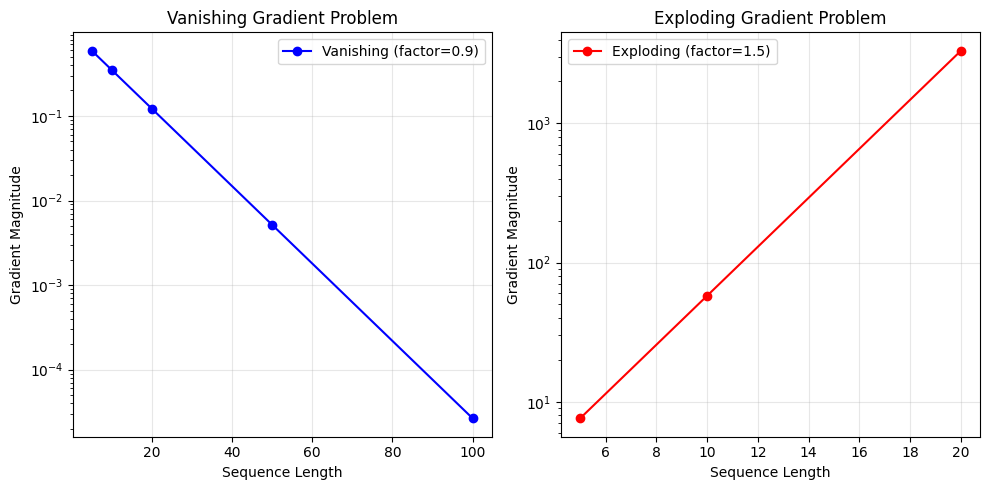

Gradient Values:
Sequence length   5: Gradient = 0.590490
Sequence length  10: Gradient = 0.348678
Sequence length  20: Gradient = 0.121577
Sequence length  50: Gradient = 0.005154
Sequence length 100: Gradient = 0.000027


In [15]:
# Demonstrate gradient flow in RNNs
def demonstrate_gradient_problem():
    sequence_lengths = [5, 10, 20, 50, 100]
    gradients_vanilla = []
    
    for seq_len in sequence_lengths:
        # Simulate gradient flow through time
        # Assuming gradient multiplied by 0.9 at each step (vanishing)
        final_gradient = 0.9 ** seq_len
        gradients_vanilla.append(final_gradient)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(sequence_lengths, gradients_vanilla, 'b-o', label='Vanishing (factor=0.9)')
    plt.xlabel('Sequence Length')
    plt.ylabel('Gradient Magnitude')
    plt.title('Vanishing Gradient Problem')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Exploding gradient
    gradients_exploding = []
    for seq_len in sequence_lengths[:3]:  # Only short sequences for exploding
        final_gradient = 1.5 ** seq_len
        gradients_exploding.append(final_gradient)
    
    plt.subplot(1, 2, 2)
    plt.plot(sequence_lengths[:3], gradients_exploding, 'r-o', label='Exploding (factor=1.5)')
    plt.xlabel('Sequence Length')
    plt.ylabel('Gradient Magnitude')
    plt.title('Exploding Gradient Problem')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Gradient Values:")
    print("=" * 40)
    for seq_len, grad in zip(sequence_lengths, gradients_vanilla):
        print(f"Sequence length {seq_len:3}: Gradient = {grad:.6f}")

demonstrate_gradient_problem()

## 5. Bidirectional RNNs <a id='5-bidirectional'></a>

### Motivation

Standard RNNs only process information from past to future. Bidirectional RNNs process sequences in both directions, capturing context from both past and future.

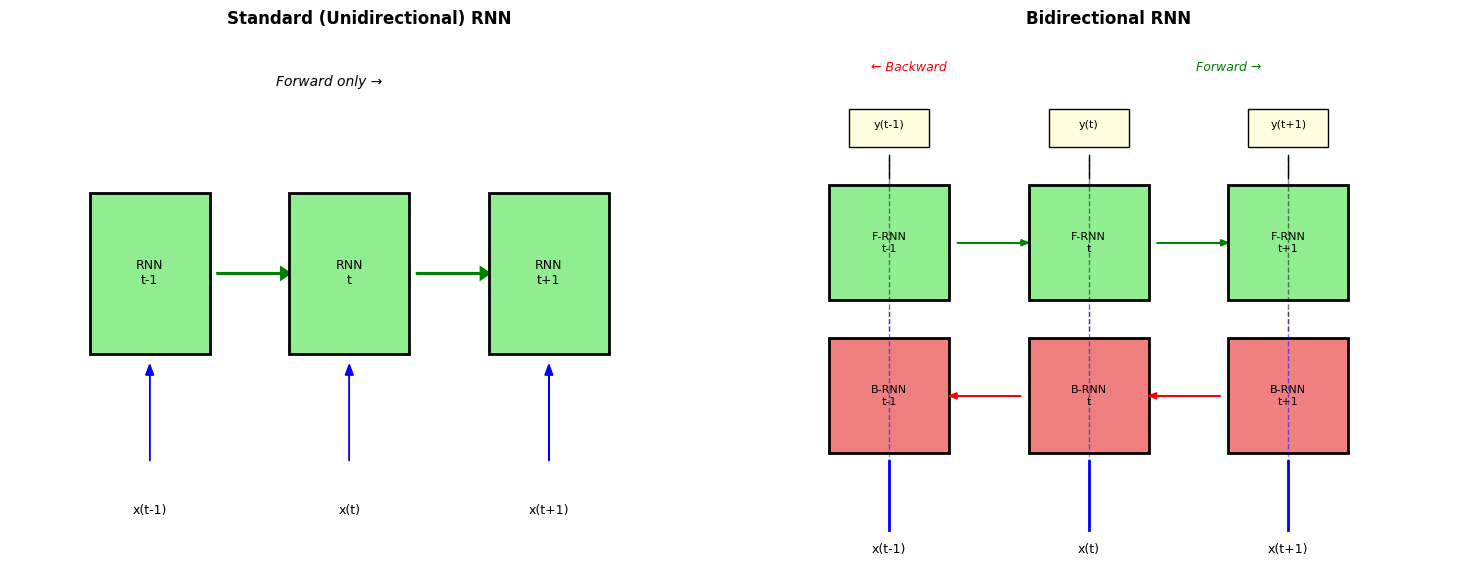

In [35]:
# Visualization of Bidirectional RNN
def visualize_bidirectional_rnn():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    plt.rcParams.update({'font.size': 14})
    # Standard RNN
    ax1.set_title('Standard (Unidirectional) RNN', fontsize=12, fontweight='bold')
    time_steps = ['t-1', 't', 't+1']
    
    for i, t in enumerate(time_steps):
        x_pos = i * 2.5 + 1
        
        # RNN cell
        rect = plt.Rectangle((x_pos, 1.5), 1.5, 1.5, fill=True,
                            facecolor='lightgreen', edgecolor='black', linewidth=2)
        ax1.add_patch(rect)
        ax1.text(x_pos + 0.75, 2.25, f'RNN\n{t}', ha='center', va='center', fontsize=9)
        
        # Input
        ax1.arrow(x_pos + 0.75, 0.5, 0, 0.8, head_width=0.1, head_length=0.1,
                 fc='blue', ec='blue')
        ax1.text(x_pos + 0.75, 0, f'x({t})', ha='center', fontsize=9)
        
        # Forward connection
        if i < len(time_steps) - 1:
            ax1.arrow(x_pos + 1.6, 2.25, 0.8, 0, head_width=0.1, head_length=0.1,
                     fc='green', ec='green', linewidth=2)
    
    ax1.text(4, 4, 'Forward only →', ha='center', fontsize=10, style='italic')
    ax1.set_xlim(0, 9)
    ax1.set_ylim(-0.5, 4.5)
    ax1.axis('off')
    
    # Bidirectional RNN
    ax2.set_title('Bidirectional RNN', fontsize=12, fontweight='bold')
    
    for i, t in enumerate(time_steps):
        x_pos = i * 2.5 + 1
        
        # Forward RNN cell
        rect_f = plt.Rectangle((x_pos, 2.5), 1.5, 1.5, fill=True,
                              facecolor='lightgreen', edgecolor='black', linewidth=2)
        ax2.add_patch(rect_f)
        ax2.text(x_pos + 0.75, 3.25, f'F-RNN\n{t}', ha='center', va='center', fontsize=8)
        
        # Backward RNN cell
        rect_b = plt.Rectangle((x_pos, 0.5), 1.5, 1.5, fill=True,
                              facecolor='lightcoral', edgecolor='black', linewidth=2)
        ax2.add_patch(rect_b)
        ax2.text(x_pos + 0.75, 1.25, f'B-RNN\n{t}', ha='center', va='center', fontsize=8)
        
        # Input (shared)
        ax2.plot([x_pos + 0.75, x_pos + 0.75], [-0.5, 0.4], 'b-', linewidth=2)
        ax2.plot([x_pos + 0.75, x_pos + 0.75], [-0.5, 2.4], 'b--', linewidth=1, alpha=0.5)
        ax2.text(x_pos + 0.75, -0.8, f'x({t})', ha='center', fontsize=9)
        
        # Forward connections
        if i < len(time_steps) - 1:
            ax2.arrow(x_pos + 1.6, 3.25, 0.8, 0, head_width=0.08, head_length=0.1,
                     fc='green', ec='green')
        
        # Backward connections
        if i > 0:
            ax2.arrow(x_pos - 0.1, 1.25, -0.8, 0, head_width=0.08, head_length=0.1,
                     fc='red', ec='red')
        
        # Output (concatenated)
        ax2.add_patch(plt.Rectangle((x_pos + 0.25, 4.5), 1, 0.5, fill=True,
                                   facecolor='lightyellow', edgecolor='black'))
        ax2.text(x_pos + 0.75, 4.75, f'y({t})', ha='center', fontsize=8)
        ax2.plot([x_pos + 0.75, x_pos + 0.75], [4.1, 4.4], 'k-', linewidth=1)
        ax2.plot([x_pos + 0.75, x_pos + 0.75], [2.1, 4.4], 'k--', linewidth=1, alpha=0.5)
    
    ax2.text(2, 5.5, '← Backward', ha='center', fontsize=9, color='red', style='italic')
    ax2.text(6, 5.5, 'Forward →', ha='center', fontsize=9, color='green', style='italic')
    
    ax2.set_xlim(0, 9)
    ax2.set_ylim(-1, 6)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_bidirectional_rnn()

### Implementation of Bidirectional RNN

In [17]:
# Bidirectional RNN implementation
class BidirectionalRNN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        
        # Bidirectional wrapper around LSTM
        self.bidirectional_rnn = layers.Bidirectional(
            layers.LSTM(rnn_units, return_sequences=True),
            merge_mode='concat'  # Can be 'sum', 'mul', 'concat', 'ave'
        )
        
        self.dense = layers.Dense(vocab_size, activation='softmax')
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.bidirectional_rnn(x)
        return self.dense(x)

# Create and test the model
bi_model = BidirectionalRNN(vocab_size=1000, embedding_dim=64, rnn_units=128)

# Create dummy input
dummy_input = tf.random.uniform((32, 20), minval=0, maxval=1000, dtype=tf.int32)
output = bi_model(dummy_input)

print("Bidirectional RNN Model:")
print("=" * 40)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"\nNote: Output dimension is 2*rnn_units due to concatenation")
print(f"      of forward and backward states")

Bidirectional RNN Model:
Input shape: (32, 20)
Output shape: (32, 20, 1000)

Note: Output dimension is 2*rnn_units due to concatenation
      of forward and backward states


## 6. Deep Recurrent Networks <a id='6-deep-rnn'></a>

### Stacking RNN Layers

Deep RNNs stack multiple recurrent layers to learn hierarchical representations.

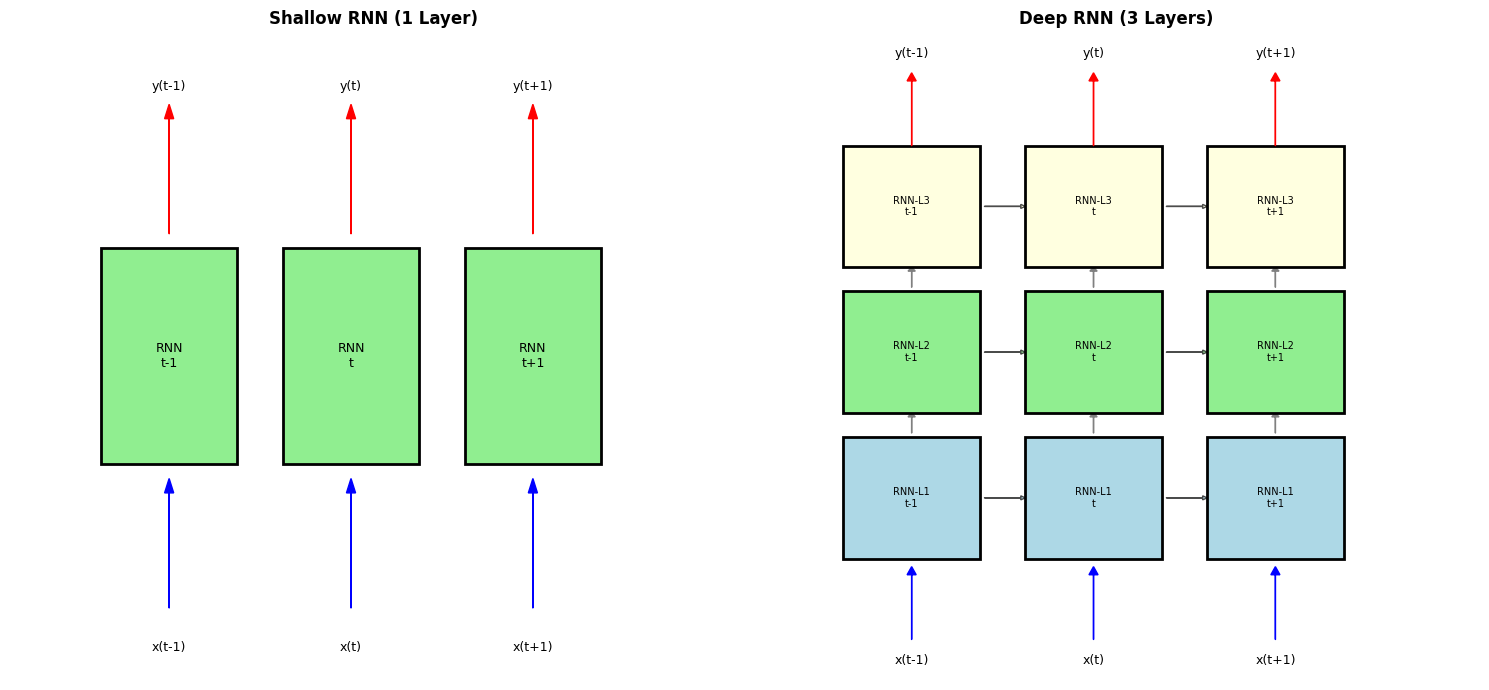

In [18]:
# Visualization of Deep RNN
def visualize_deep_rnn():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Shallow RNN
    ax1.set_title('Shallow RNN (1 Layer)', fontsize=12, fontweight='bold')
    time_steps = ['t-1', 't', 't+1']
    
    for i, t in enumerate(time_steps):
        x_pos = i * 2 + 1
        
        # Single RNN layer
        rect = plt.Rectangle((x_pos, 1), 1.5, 1.5, fill=True,
                            facecolor='lightgreen', edgecolor='black', linewidth=2)
        ax1.add_patch(rect)
        ax1.text(x_pos + 0.75, 1.75, f'RNN\n{t}', ha='center', va='center', fontsize=9)
        
        # Input
        ax1.arrow(x_pos + 0.75, 0, 0, 0.8, head_width=0.1, head_length=0.1,
                 fc='blue', ec='blue')
        ax1.text(x_pos + 0.75, -0.3, f'x({t})', ha='center', fontsize=9)
        
        # Output
        ax1.arrow(x_pos + 0.75, 2.6, 0, 0.8, head_width=0.1, head_length=0.1,
                 fc='red', ec='red')
        ax1.text(x_pos + 0.75, 3.6, f'y({t})', ha='center', fontsize=9)
    
    ax1.set_xlim(0, 8)
    ax1.set_ylim(-0.5, 4)
    ax1.axis('off')
    
    # Deep RNN
    ax2.set_title('Deep RNN (3 Layers)', fontsize=12, fontweight='bold')
    
    colors = ['lightblue', 'lightgreen', 'lightyellow']
    layer_names = ['RNN-L1', 'RNN-L2', 'RNN-L3']
    
    for i, t in enumerate(time_steps):
        x_pos = i * 2 + 1
        
        # Multiple RNN layers
        for layer_idx, (color, name) in enumerate(zip(colors, layer_names)):
            y_pos = 1 + layer_idx * 1.8
            
            rect = plt.Rectangle((x_pos, y_pos), 1.5, 1.5, fill=True,
                                facecolor=color, edgecolor='black', linewidth=2)
            ax2.add_patch(rect)
            ax2.text(x_pos + 0.75, y_pos + 0.75, f'{name}\n{t}', 
                    ha='center', va='center', fontsize=7)
            
            # Vertical connections between layers
            if layer_idx < len(colors) - 1:
                ax2.arrow(x_pos + 0.75, y_pos + 1.55, 0, 0.2,
                         head_width=0.08, head_length=0.05, fc='gray', ec='gray')
            
            # Horizontal connections within layer
            if i < len(time_steps) - 1:
                ax2.arrow(x_pos + 1.55, y_pos + 0.75, 0.4, 0,
                         head_width=0.05, head_length=0.05, 
                         fc=color, ec='black', alpha=0.7)
        
        # Input
        ax2.arrow(x_pos + 0.75, 0, 0, 0.8, head_width=0.1, head_length=0.1,
                 fc='blue', ec='blue')
        ax2.text(x_pos + 0.75, -0.3, f'x({t})', ha='center', fontsize=9)
        
        # Output (from top layer)
        ax2.arrow(x_pos + 0.75, 6.1, 0, 0.8, head_width=0.1, head_length=0.1,
                 fc='red', ec='red')
        ax2.text(x_pos + 0.75, 7.2, f'y({t})', ha='center', fontsize=9)
    
    ax2.set_xlim(0, 8)
    ax2.set_ylim(-0.5, 7.5)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_deep_rnn()

### Implementation of Deep RNN

In [20]:
# Deep RNN implementation with multiple layers
def create_deep_rnn(num_layers=3, units_per_layer=128, dropout_rate=0.2):
    model = tf.keras.Sequential()
    
    # Add embedding layer
    model.add(layers.Embedding(10000, 128))
    
    # Add multiple RNN layers
    for i in range(num_layers):
        return_sequences = True  # All layers return sequences
        
        if i == 0:
            # First layer
            model.add(layers.LSTM(units_per_layer, 
                                 return_sequences=return_sequences,
                                 dropout=dropout_rate))
        elif i == num_layers - 1:
            # Last layer (might not return sequences depending on task)
            model.add(layers.LSTM(units_per_layer, 
                                 return_sequences=False,
                                 dropout=dropout_rate))
        else:
            # Middle layers
            model.add(layers.LSTM(units_per_layer, 
                                 return_sequences=return_sequences,
                                 dropout=dropout_rate))
    
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

# Create models with different depths
shallow_model = create_deep_rnn(num_layers=1)
deep_model = create_deep_rnn(num_layers=3)
very_deep_model = create_deep_rnn(num_layers=5)

# Build models before calling count_params or summary
input_shape = (batch_size, seq_length)
shallow_model.build(input_shape)
deep_model.build(input_shape)
very_deep_model.build(input_shape)

print("Model Comparison:")
print("=" * 50)
print(f"Shallow (1 layer):     {shallow_model.count_params():,} parameters")
print(f"Deep (3 layers):       {deep_model.count_params():,} parameters")
print(f"Very Deep (5 layers):  {very_deep_model.count_params():,} parameters")

# Show architecture of deep model
print("\nDeep Model Architecture:")
print("=" * 50)
deep_model.summary()

Model Comparison:
Shallow (1 layer):     1,412,874 parameters
Deep (3 layers):       1,676,042 parameters
Very Deep (5 layers):  1,939,210 parameters

Deep Model Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (32, 100, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (32, 100, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (32, 100, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (32, 128)              │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,042 (6.39 MB)

 Trainable params: 1,676,042 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Long Short-Term Memory (LSTM) <a id='7-lstm'></a>

### The LSTM Cell

LSTMs solve the vanishing gradient problem through a gating mechanism that controls information flow.

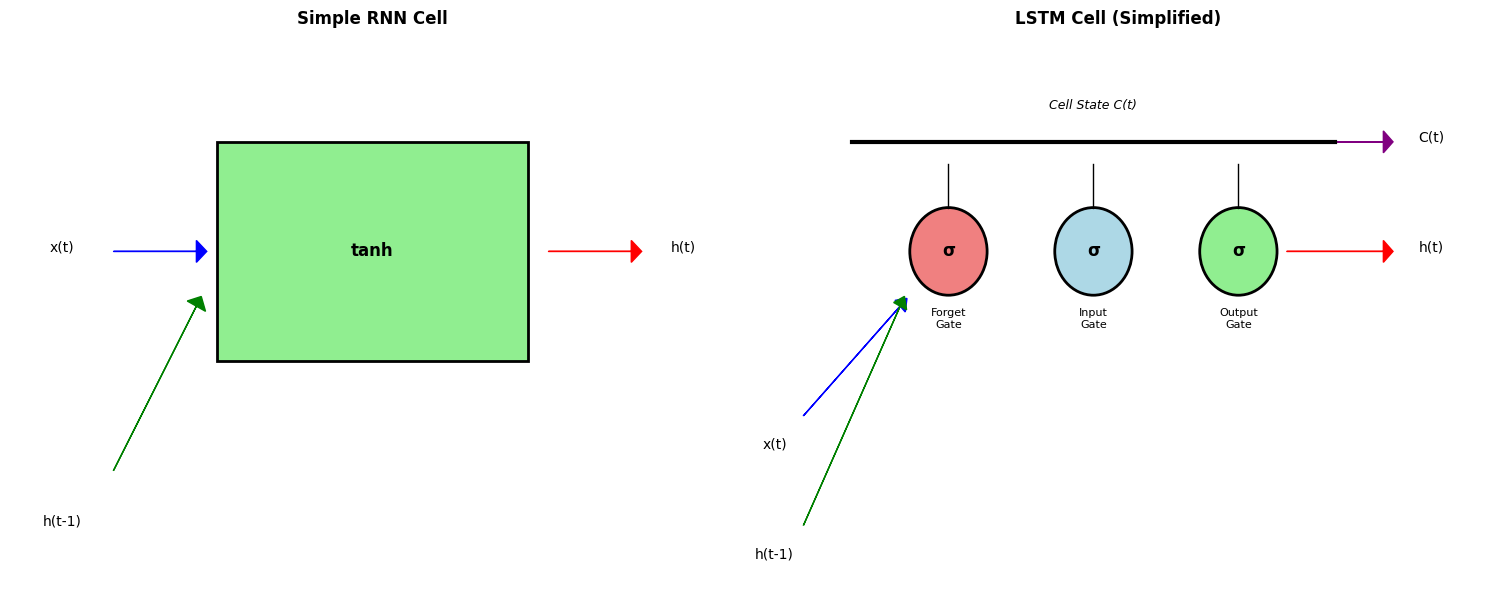

In [21]:
# LSTM Architecture Visualization
def visualize_lstm_cell():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Simple RNN vs LSTM comparison
    ax1.set_title('Simple RNN Cell', fontsize=12, fontweight='bold')
    
    # RNN cell
    ax1.add_patch(plt.Rectangle((2, 2), 3, 2, fill=True,
                               facecolor='lightgreen', edgecolor='black', linewidth=2))
    ax1.text(3.5, 3, 'tanh', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Inputs and outputs
    ax1.arrow(1, 3, 0.8, 0, head_width=0.2, head_length=0.1, fc='blue', ec='blue')
    ax1.text(0.5, 3, 'x(t)', ha='center', fontsize=10)
    ax1.arrow(1, 1, 0.8, 1.5, head_width=0.2, head_length=0.1, fc='green', ec='green')
    ax1.text(0.5, 0.5, 'h(t-1)', ha='center', fontsize=10)
    ax1.arrow(5.2, 3, 0.8, 0, head_width=0.2, head_length=0.1, fc='red', ec='red')
    ax1.text(6.5, 3, 'h(t)', ha='center', fontsize=10)
    
    ax1.set_xlim(0, 7)
    ax1.set_ylim(0, 5)
    ax1.axis('off')
    
    # LSTM cell
    ax2.set_title('LSTM Cell (Simplified)', fontsize=12, fontweight='bold')
    
    # Cell state line
    ax2.plot([1, 6], [4, 4], 'k-', linewidth=3)
    ax2.text(3.5, 4.3, 'Cell State C(t)', ha='center', fontsize=9, style='italic')
    
    # Gates
    gates = [
        (2, 'Forget\nGate', 'lightcoral'),
        (3.5, 'Input\nGate', 'lightblue'),
        (5, 'Output\nGate', 'lightgreen')
    ]
    
    for x_pos, name, color in gates:
        ax2.add_patch(plt.Circle((x_pos, 3), 0.4, fill=True,
                                facecolor=color, edgecolor='black', linewidth=2))
        ax2.text(x_pos, 3, 'σ', ha='center', va='center', fontsize=12, fontweight='bold')
        ax2.text(x_pos, 2.3, name, ha='center', fontsize=8)
        
        # Connect to cell state
        ax2.plot([x_pos, x_pos], [3.4, 3.8], 'k-', linewidth=1)
    
    # Inputs
    ax2.arrow(0.5, 1.5, 1, 1, head_width=0.15, head_length=0.1, fc='blue', ec='blue')
    ax2.text(0.2, 1.2, 'x(t)', ha='center', fontsize=10)
    ax2.arrow(0.5, 0.5, 1, 2, head_width=0.15, head_length=0.1, fc='green', ec='green')
    ax2.text(0.2, 0.2, 'h(t-1)', ha='center', fontsize=10)
    
    # Outputs
    ax2.arrow(5.5, 3, 1, 0, head_width=0.2, head_length=0.1, fc='red', ec='red')
    ax2.text(7, 3, 'h(t)', ha='center', fontsize=10)
    ax2.arrow(6, 4, 0.5, 0, head_width=0.2, head_length=0.1, fc='purple', ec='purple')
    ax2.text(7, 4, 'C(t)', ha='center', fontsize=10)
    
    ax2.set_xlim(0, 7.5)
    ax2.set_ylim(0, 5)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_lstm_cell()

### LSTM Gates Explained

1. **Forget Gate**: Decides what information to throw away from cell state
   $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$

2. **Input Gate**: Decides which values to update
   $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
   $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

3. **Cell State Update**:
   $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$

4. **Output Gate**: Decides what parts of cell state to output
   $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
   $h_t = o_t * \tanh(C_t)$

In [22]:
# LSTM implementation from scratch (simplified)
class LSTMCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Initialize weights for gates
        self.Wf = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wi = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wo = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wc = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        
        # Initialize biases
        self.bf = np.zeros((hidden_dim, 1))
        self.bi = np.zeros((hidden_dim, 1))
        self.bo = np.zeros((hidden_dim, 1))
        self.bc = np.zeros((hidden_dim, 1))
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x, h_prev, c_prev):
        # Concatenate input and previous hidden state
        concat = np.vstack([h_prev, x])
        
        # Forget gate
        f = self.sigmoid(np.dot(self.Wf, concat) + self.bf)
        
        # Input gate
        i = self.sigmoid(np.dot(self.Wi, concat) + self.bi)
        
        # Candidate values
        c_tilde = np.tanh(np.dot(self.Wc, concat) + self.bc)
        
        # Update cell state
        c = f * c_prev + i * c_tilde
        
        # Output gate
        o = self.sigmoid(np.dot(self.Wo, concat) + self.bo)
        
        # Hidden state
        h = o * np.tanh(c)
        
        return h, c, f, i, o

# Test LSTM cell
lstm_cell = LSTMCell(input_dim=10, hidden_dim=20)
x = np.random.randn(10, 1)
h_prev = np.zeros((20, 1))
c_prev = np.zeros((20, 1))

h, c, f, i, o = lstm_cell.forward(x, h_prev, c_prev)

print("LSTM Cell Forward Pass:")
print("=" * 40)
print(f"Input shape: {x.shape}")
print(f"Hidden state shape: {h.shape}")
print(f"Cell state shape: {c.shape}")
print(f"\nGate activations (average):")
print(f"  Forget gate: {f.mean():.3f}")
print(f"  Input gate:  {i.mean():.3f}")
print(f"  Output gate: {o.mean():.3f}")

LSTM Cell Forward Pass:
Input shape: (10, 1)
Hidden state shape: (20, 1)
Cell state shape: (20, 1)

Gate activations (average):
  Forget gate: 0.500
  Input gate:  0.503
  Output gate: 0.500


### LSTM vs Simple RNN Performance

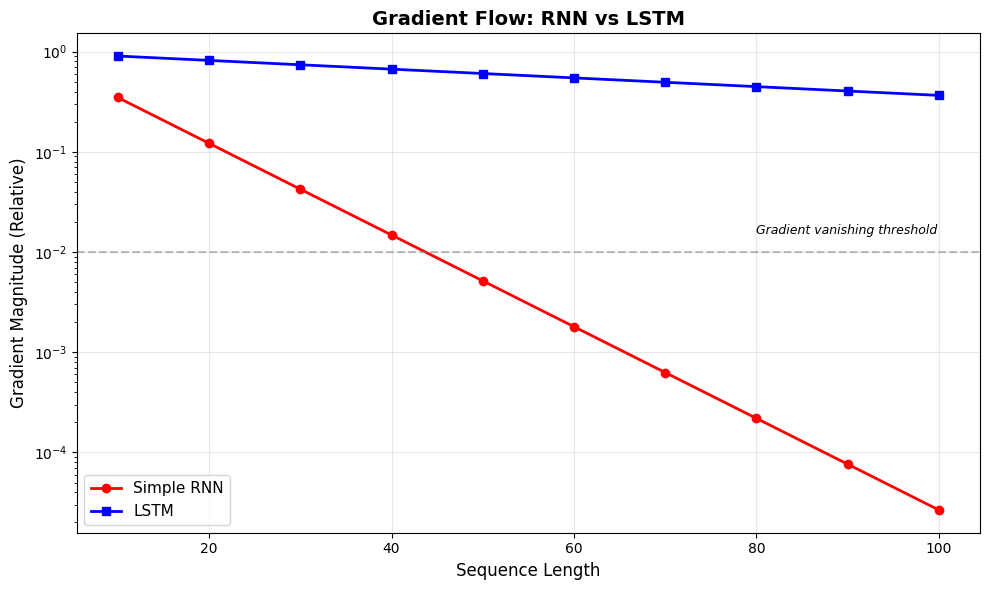

Gradient Preservation Comparison:
Seq Length |    RNN Gradient |   LSTM Gradient
--------------------------------------------------
        10 |        0.348678 |        0.904382
        20 |        0.121577 |        0.817907
        30 |        0.042391 |        0.739700
        40 |        0.014781 |        0.668972
        50 |        0.005154 |        0.605006
        60 |        0.001797 |        0.547157
        70 |        0.000627 |        0.494839
        80 |        0.000218 |        0.447523
        90 |        0.000076 |        0.404732
       100 |        0.000027 |        0.366032


In [23]:
# Compare gradient flow in LSTM vs RNN
def compare_gradient_flow():
    sequence_lengths = np.arange(10, 110, 10)
    
    # Simulate gradient flow
    rnn_gradients = [0.9 ** seq_len for seq_len in sequence_lengths]
    lstm_gradients = [0.99 ** seq_len for seq_len in sequence_lengths]  # LSTM preserves gradients better
    
    plt.figure(figsize=(10, 6))
    plt.plot(sequence_lengths, rnn_gradients, 'r-o', label='Simple RNN', linewidth=2)
    plt.plot(sequence_lengths, lstm_gradients, 'b-s', label='LSTM', linewidth=2)
    
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel('Gradient Magnitude (Relative)', fontsize=12)
    plt.title('Gradient Flow: RNN vs LSTM', fontsize=14, fontweight='bold')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Add annotations
    plt.axhline(y=0.01, color='gray', linestyle='--', alpha=0.5)
    plt.text(80, 0.015, 'Gradient vanishing threshold', fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    print("Gradient Preservation Comparison:")
    print("=" * 50)
    print(f"{'Seq Length':>10} | {'RNN Gradient':>15} | {'LSTM Gradient':>15}")
    print("-" * 50)
    for seq_len, rnn_grad, lstm_grad in zip(sequence_lengths, rnn_gradients, lstm_gradients):
        print(f"{seq_len:>10} | {rnn_grad:>15.6f} | {lstm_grad:>15.6f}")

compare_gradient_flow()

## 8. Gated Recurrent Units (GRUs) <a id='8-gru'></a>

### GRU Architecture

GRUs are a simplified version of LSTMs with fewer parameters but similar performance.

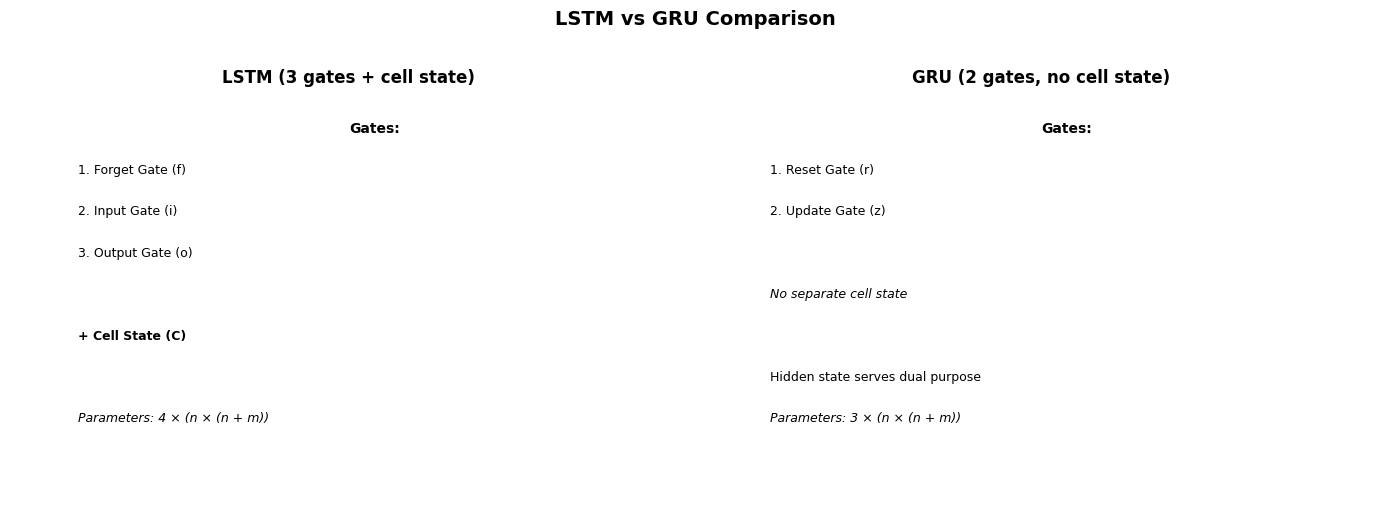

In [24]:
# GRU vs LSTM comparison
def visualize_gru_vs_lstm():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # LSTM
    ax1.set_title('LSTM (3 gates + cell state)', fontsize=12, fontweight='bold')
    ax1.text(0.5, 0.9, 'Gates:', fontsize=10, fontweight='bold', transform=ax1.transAxes)
    gates_lstm = ['1. Forget Gate (f)', '2. Input Gate (i)', '3. Output Gate (o)']
    for i, gate in enumerate(gates_lstm):
        ax1.text(0.1, 0.8-i*0.1, gate, fontsize=9, transform=ax1.transAxes)
    ax1.text(0.1, 0.4, '+ Cell State (C)', fontsize=9, fontweight='bold', transform=ax1.transAxes)
    ax1.text(0.1, 0.2, 'Parameters: 4 × (n × (n + m))', fontsize=9, 
            style='italic', transform=ax1.transAxes)
    ax1.axis('off')
    
    # GRU
    ax2.set_title('GRU (2 gates, no cell state)', fontsize=12, fontweight='bold')
    ax2.text(0.5, 0.9, 'Gates:', fontsize=10, fontweight='bold', transform=ax2.transAxes)
    gates_gru = ['1. Reset Gate (r)', '2. Update Gate (z)']
    for i, gate in enumerate(gates_gru):
        ax2.text(0.1, 0.8-i*0.1, gate, fontsize=9, transform=ax2.transAxes)
    ax2.text(0.1, 0.5, 'No separate cell state', fontsize=9, style='italic', transform=ax2.transAxes)
    ax2.text(0.1, 0.3, 'Hidden state serves dual purpose', fontsize=9, transform=ax2.transAxes)
    ax2.text(0.1, 0.2, 'Parameters: 3 × (n × (n + m))', fontsize=9,
            style='italic', transform=ax2.transAxes)
    ax2.axis('off')
    
    plt.suptitle('LSTM vs GRU Comparison', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_gru_vs_lstm()

### GRU Equations

1. **Reset Gate**: Controls how much past information to forget
   $r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$

2. **Update Gate**: Controls how much past information to pass along
   $z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$

3. **Candidate Hidden State**:
   $\tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])$

4. **Final Hidden State**:
   $h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$

In [25]:
# GRU implementation
class GRUCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Initialize weights
        self.Wr = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wz = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wh = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        
        # Initialize biases
        self.br = np.zeros((hidden_dim, 1))
        self.bz = np.zeros((hidden_dim, 1))
        self.bh = np.zeros((hidden_dim, 1))
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x, h_prev):
        # Concatenate input and previous hidden state
        concat = np.vstack([h_prev, x])
        
        # Reset gate
        r = self.sigmoid(np.dot(self.Wr, concat) + self.br)
        
        # Update gate
        z = self.sigmoid(np.dot(self.Wz, concat) + self.bz)
        
        # Candidate hidden state
        concat_reset = np.vstack([r * h_prev, x])
        h_tilde = np.tanh(np.dot(self.Wh, concat_reset) + self.bh)
        
        # Final hidden state
        h = (1 - z) * h_prev + z * h_tilde
        
        return h, r, z

# Test GRU cell
gru_cell = GRUCell(input_dim=10, hidden_dim=20)
x = np.random.randn(10, 1)
h_prev = np.zeros((20, 1))

h, r, z = gru_cell.forward(x, h_prev)

print("GRU Cell Forward Pass:")
print("=" * 40)
print(f"Input shape: {x.shape}")
print(f"Hidden state shape: {h.shape}")
print(f"\nGate activations (average):")
print(f"  Reset gate:  {r.mean():.3f}")
print(f"  Update gate: {z.mean():.3f}")

GRU Cell Forward Pass:
Input shape: (10, 1)
Hidden state shape: (20, 1)

Gate activations (average):
  Reset gate:  0.504
  Update gate: 0.502


### Comparing LSTM and GRU Performance

In [26]:
# Build and compare LSTM vs GRU models
def build_comparison_models(seq_length=50, vocab_size=1000):
    # LSTM model
    lstm_model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 128),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(10, activation='softmax')
    ])
    
    # GRU model
    gru_model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 128),
        layers.GRU(128, return_sequences=True),
        layers.GRU(64),
        layers.Dense(10, activation='softmax')
    ])
    
    # Build models with dummy input
    dummy_input = tf.zeros((1, seq_length), dtype=tf.int32)
    lstm_model(dummy_input)
    gru_model(dummy_input)
    
    return lstm_model, gru_model

lstm_model, gru_model = build_comparison_models()

print("Model Comparison: LSTM vs GRU")
print("=" * 50)
print(f"LSTM total parameters: {lstm_model.count_params():,}")
print(f"GRU total parameters:  {gru_model.count_params():,}")
print(f"\nParameter difference: {lstm_model.count_params() - gru_model.count_params():,}")
print(f"GRU has {(1 - gru_model.count_params()/lstm_model.count_params())*100:.1f}% fewer parameters")

Model Comparison: LSTM vs GRU
LSTM total parameters: 309,642
GRU total parameters:  264,970

Parameter difference: 44,672
GRU has 14.4% fewer parameters


## 9. Recursive Neural Networks <a id='9-recursive'></a>

### Recursive vs Recurrent

While RNNs process sequences linearly, Recursive Neural Networks process hierarchical tree structures.

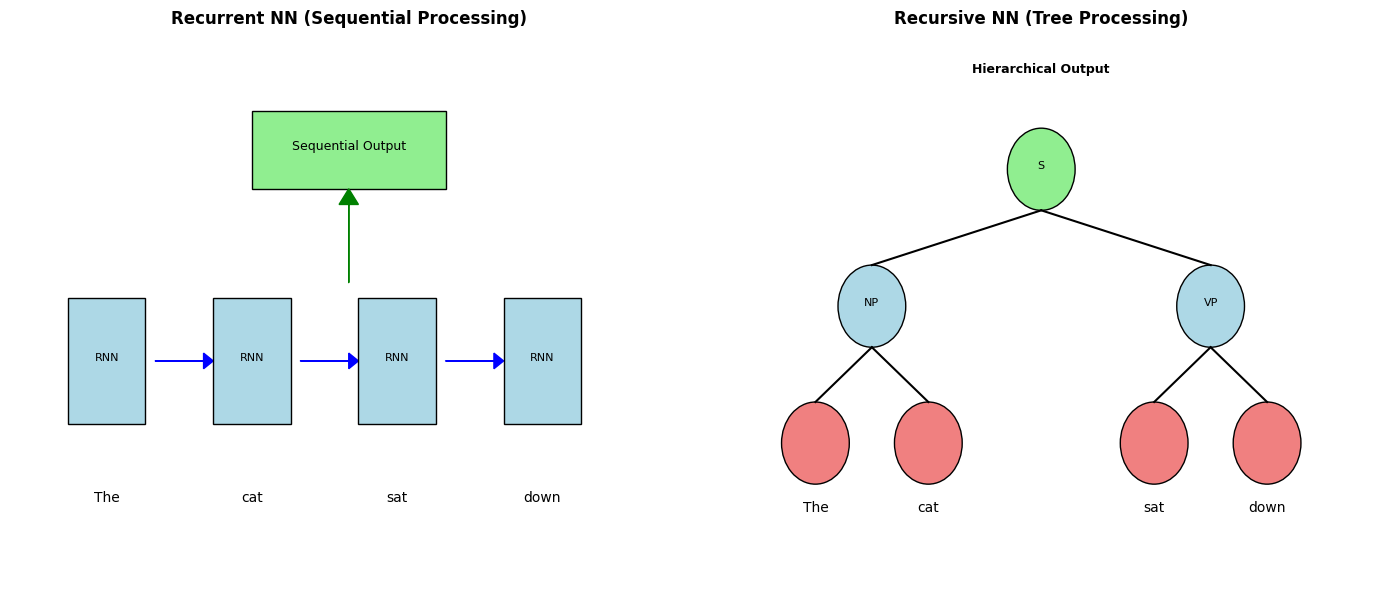

In [27]:
# Visualization of Recursive Neural Networks
def visualize_recursive_nn():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Recurrent (Sequential)
    ax1.set_title('Recurrent NN (Sequential Processing)', fontsize=12, fontweight='bold')
    words = ['The', 'cat', 'sat', 'down']
    
    for i, word in enumerate(words):
        x = i * 1.5 + 1
        # Word
        ax1.text(x, 0, word, ha='center', fontsize=10)
        # RNN cell
        ax1.add_patch(plt.Rectangle((x-0.4, 0.5), 0.8, 0.8,
                                   facecolor='lightblue', edgecolor='black'))
        ax1.text(x, 0.9, 'RNN', ha='center', fontsize=8)
        # Arrow to next
        if i < len(words) - 1:
            ax1.arrow(x + 0.5, 0.9, 0.5, 0, head_width=0.1, head_length=0.1,
                     fc='blue', ec='blue')
    
    # Output
    ax1.add_patch(plt.Rectangle((2.5, 2), 2, 0.5,
                               facecolor='lightgreen', edgecolor='black'))
    ax1.text(3.5, 2.25, 'Sequential Output', ha='center', fontsize=9)
    ax1.arrow(3.5, 1.4, 0, 0.5, head_width=0.2, head_length=0.1,
             fc='green', ec='green')
    
    ax1.set_xlim(0, 7)
    ax1.set_ylim(-0.5, 3)
    ax1.axis('off')
    
    # Recursive (Tree-based)
    ax2.set_title('Recursive NN (Tree Processing)', fontsize=12, fontweight='bold')
    
    # Tree structure for "The cat sat down"
    # Leaves (words)
    words_pos = [(1, 0, 'The'), (2, 0, 'cat'), (4, 0, 'sat'), (5, 0, 'down')]
    for x, y, word in words_pos:
        ax2.text(x, y, word, ha='center', fontsize=10)
        ax2.add_patch(plt.Circle((x, y + 0.5), 0.3,
                                facecolor='lightcoral', edgecolor='black'))
    
    # First level combinations
    ax2.add_patch(plt.Circle((1.5, 1.5), 0.3,
                            facecolor='lightblue', edgecolor='black'))
    ax2.text(1.5, 1.5, 'NP', ha='center', fontsize=8)  # Noun Phrase
    ax2.plot([1, 1.5], [0.8, 1.2], 'k-')
    ax2.plot([2, 1.5], [0.8, 1.2], 'k-')
    
    ax2.add_patch(plt.Circle((4.5, 1.5), 0.3,
                            facecolor='lightblue', edgecolor='black'))
    ax2.text(4.5, 1.5, 'VP', ha='center', fontsize=8)  # Verb Phrase
    ax2.plot([4, 4.5], [0.8, 1.2], 'k-')
    ax2.plot([5, 4.5], [0.8, 1.2], 'k-')
    
    # Root
    ax2.add_patch(plt.Circle((3, 2.5), 0.3,
                            facecolor='lightgreen', edgecolor='black'))
    ax2.text(3, 2.5, 'S', ha='center', fontsize=8)  # Sentence
    ax2.plot([1.5, 3], [1.8, 2.2], 'k-')
    ax2.plot([4.5, 3], [1.8, 2.2], 'k-')
    
    ax2.text(3, 3.2, 'Hierarchical Output', ha='center', fontsize=9, fontweight='bold')
    
    ax2.set_xlim(0, 6)
    ax2.set_ylim(-0.5, 3.5)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_recursive_nn()

### Recursive Neural Network Implementation

In [28]:
# Simple Recursive Neural Network for binary tree
class RecursiveNN:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Weight matrix for combining children
        self.W = np.random.randn(hidden_dim, 2 * input_dim) * 0.01
        self.b = np.zeros((hidden_dim, 1))
        
    def combine_children(self, left_child, right_child):
        """Combine two child nodes into parent representation"""
        concatenated = np.concatenate([left_child, right_child], axis=0)
        parent = np.tanh(np.dot(self.W, concatenated) + self.b)
        return parent
    
    def forward_tree(self, tree):
        """Process tree recursively"""
        if tree.is_leaf():
            return tree.embedding
        else:
            left_repr = self.forward_tree(tree.left)
            right_repr = self.forward_tree(tree.right)
            return self.combine_children(left_repr, right_repr)

# Example tree node class
class TreeNode:
    def __init__(self, value=None, embedding=None, left=None, right=None):
        self.value = value
        self.embedding = embedding
        self.left = left
        self.right = right
        
    def is_leaf(self):
        return self.left is None and self.right is None

# Create a simple tree: ((The cat) (sat down))
embedding_dim = 10

# Leaf nodes with random embeddings
the = TreeNode("The", np.random.randn(embedding_dim, 1))
cat = TreeNode("cat", np.random.randn(embedding_dim, 1))
sat = TreeNode("sat", np.random.randn(embedding_dim, 1))
down = TreeNode("down", np.random.randn(embedding_dim, 1))

# Internal nodes
np_node = TreeNode("NP", left=the, right=cat)
vp_node = TreeNode("VP", left=sat, right=down)
root = TreeNode("S", left=np_node, right=vp_node)

# Process tree
recursive_nn = RecursiveNN(embedding_dim, embedding_dim)
root_representation = recursive_nn.forward_tree(root)

print("Recursive Neural Network Example:")
print("=" * 40)
print(f"Tree structure: ((The cat) (sat down))")
print(f"Leaf embedding dimension: {embedding_dim}")
print(f"Root representation shape: {root_representation.shape}")
print(f"Root representation (first 5 values):")
print(root_representation[:5].T)

Recursive Neural Network Example:
Tree structure: ((The cat) (sat down))
Leaf embedding dimension: 10
Root representation shape: (10, 1)
Root representation (first 5 values):
[[-0.0006781  -0.00389904 -0.00332179 -0.00236569 -0.00304831]]


## 10. Practical Implementation <a id='10-implementation'></a>

### Complete Example: Sentiment Analysis with LSTM

In [29]:
# Complete sentiment analysis example
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sample data
texts = [
    "This movie is fantastic! I loved it.",
    "Terrible film. Complete waste of time.",
    "Great acting and amazing storyline.",
    "Boring and predictable. Not recommended.",
    "One of the best movies I've ever seen!",
    "Awful. I want my money back."
]

labels = [1, 0, 1, 0, 1, 0]  # 1: positive, 0: negative

# Tokenization
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding
max_length = 10
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print("Text Processing:")
print("=" * 40)
print(f"Original text: '{texts[0]}'")
print(f"Tokenized: {sequences[0]}")
print(f"Padded: {padded_sequences[0]}")

# Build LSTM model for sentiment analysis
sentiment_model = tf.keras.Sequential([
    layers.Embedding(100, 16, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

sentiment_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
print("=" * 40)
sentiment_model.summary()

Text Processing:
Original text: 'This movie is fantastic! I loved it.'
Tokenized: [5, 6, 7, 8, 2, 9, 10]
Padded: [ 5  6  7  8  2  9 10  0  0  0]

Model Architecture:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 11. Applications and Best Practices <a id='11-applications'></a>

### Common Applications

In [30]:
# Applications overview
applications = {
    "Simple RNN": [
        "Short sequences",
        "Simple pattern recognition",
        "When computational efficiency is critical"
    ],
    "LSTM": [
        "Long sequences (100+ timesteps)",
        "Language modeling",
        "Speech recognition",
        "Machine translation"
    ],
    "GRU": [
        "Similar to LSTM tasks",
        "When you need fewer parameters",
        "Faster training needed"
    ],
    "Bidirectional RNN": [
        "When future context is available",
        "Named Entity Recognition",
        "Part-of-speech tagging",
        "Machine translation"
    ],
    "Deep RNN": [
        "Complex patterns requiring hierarchy",
        "Large-scale language models",
        "Advanced speech recognition"
    ],
    "Recursive NN": [
        "Parsing syntactic trees",
        "Sentiment analysis with structure",
        "Image scene parsing"
    ]
}

print("RNN Architecture Selection Guide:")
print("=" * 60)
for arch, uses in applications.items():
    print(f"\n{arch}:")
    for use in uses:
        print(f"  • {use}")

RNN Architecture Selection Guide:

Simple RNN:
  • Short sequences
  • Simple pattern recognition
  • When computational efficiency is critical

LSTM:
  • Long sequences (100+ timesteps)
  • Language modeling
  • Speech recognition
  • Machine translation

GRU:
  • Similar to LSTM tasks
  • When you need fewer parameters
  • Faster training needed

Bidirectional RNN:
  • When future context is available
  • Named Entity Recognition
  • Part-of-speech tagging
  • Machine translation

Deep RNN:
  • Complex patterns requiring hierarchy
  • Large-scale language models
  • Advanced speech recognition

Recursive NN:
  • Parsing syntactic trees
  • Sentiment analysis with structure
  • Image scene parsing


### Best Practices and Tips

In [31]:
# Best practices summary
best_practices = [
    {
        "category": "Data Preparation",
        "tips": [
            "Normalize/standardize input sequences",
            "Handle variable-length sequences with padding or bucketing",
            "Use appropriate sequence length (not too long for simple RNN)",
            "Consider data augmentation for small datasets"
        ]
    },
    {
        "category": "Architecture Design",
        "tips": [
            "Start simple, add complexity if needed",
            "Use LSTM/GRU for sequences > 10-20 steps",
            "Consider bidirectional for non-causal tasks",
            "Stack layers for complex patterns (but not too many)"
        ]
    },
    {
        "category": "Training",
        "tips": [
            "Use gradient clipping to prevent exploding gradients",
            "Start with Adam optimizer",
            "Use dropout for regularization (0.2-0.5)",
            "Monitor for overfitting with validation data"
        ]
    },
    {
        "category": "Hyperparameters",
        "tips": [
            "Hidden size: 32-512 depending on task complexity",
            "Learning rate: 0.001 is a good starting point",
            "Batch size: 32-128 for most tasks",
            "Number of layers: 1-3 for most tasks, rarely more"
        ]
    }
]

print("Best Practices for RNN Implementation:")
print("=" * 60)
for practice in best_practices:
    print(f"\n{practice['category']}:")
    for tip in practice['tips']:
        print(f"  ✓ {tip}")

Best Practices for RNN Implementation:

Data Preparation:
  ✓ Normalize/standardize input sequences
  ✓ Handle variable-length sequences with padding or bucketing
  ✓ Use appropriate sequence length (not too long for simple RNN)
  ✓ Consider data augmentation for small datasets

Architecture Design:
  ✓ Start simple, add complexity if needed
  ✓ Use LSTM/GRU for sequences > 10-20 steps
  ✓ Consider bidirectional for non-causal tasks
  ✓ Stack layers for complex patterns (but not too many)

Training:
  ✓ Use gradient clipping to prevent exploding gradients
  ✓ Start with Adam optimizer
  ✓ Use dropout for regularization (0.2-0.5)
  ✓ Monitor for overfitting with validation data

Hyperparameters:
  ✓ Hidden size: 32-512 depending on task complexity
  ✓ Learning rate: 0.001 is a good starting point
  ✓ Batch size: 32-128 for most tasks
  ✓ Number of layers: 1-3 for most tasks, rarely more


### Common Pitfalls and Solutions

In [32]:
# Common problems and solutions
problems_solutions = [
    ("Vanishing Gradients", 
     "Use LSTM/GRU instead of simple RNN"),
    ("Exploding Gradients", 
     "Apply gradient clipping (typically clip_norm=1.0)"),
    ("Overfitting", 
     "Add dropout, reduce model size, or get more data"),
    ("Slow Training", 
     "Use GRU instead of LSTM, reduce sequence length, use GPU"),
    ("Poor Performance on Long Sequences", 
     "Use attention mechanisms or Transformer models"),
    ("Memory Issues", 
     "Reduce batch size, use gradient accumulation, truncate sequences")
]

print("Common RNN Problems and Solutions:")
print("=" * 60)
for problem, solution in problems_solutions:
    print(f"\n❌ Problem: {problem}")
    print(f"✅ Solution: {solution}")

Common RNN Problems and Solutions:

❌ Problem: Vanishing Gradients
✅ Solution: Use LSTM/GRU instead of simple RNN

❌ Problem: Exploding Gradients
✅ Solution: Apply gradient clipping (typically clip_norm=1.0)

❌ Problem: Overfitting
✅ Solution: Add dropout, reduce model size, or get more data

❌ Problem: Slow Training
✅ Solution: Use GRU instead of LSTM, reduce sequence length, use GPU

❌ Problem: Poor Performance on Long Sequences
✅ Solution: Use attention mechanisms or Transformer models

❌ Problem: Memory Issues
✅ Solution: Reduce batch size, use gradient accumulation, truncate sequences


## Summary and Key Takeaways

### What We've Learned

In [33]:
# Summary of key concepts
summary = {
    "Unfolding Computational Graphs": 
        "RNNs can be viewed as unrolled through time, showing how information flows across sequences",
    
    "Basic RNN": 
        "Simple architecture with hidden state, suffers from vanishing/exploding gradients",
    
    "Bidirectional RNN": 
        "Processes sequences in both directions, capturing past and future context",
    
    "Deep RNN": 
        "Stacks multiple RNN layers for learning hierarchical representations",
    
    "LSTM": 
        "Uses gates (forget, input, output) and cell state to handle long-term dependencies",
    
    "GRU": 
        "Simplified version of LSTM with fewer parameters but similar performance",
    
    "Recursive NN": 
        "Processes tree-structured data rather than sequences"
}

print("📚 KEY CONCEPTS SUMMARY")
print("=" * 70)
for concept, description in summary.items():
    print(f"\n📍 {concept}:")
    print(f"   {description}")

print("\n" + "=" * 70)
print("\n🎯 Quick Decision Guide:")
print("   • Short sequences (< 10 steps): Simple RNN might suffice")
print("   • Long sequences: Use LSTM or GRU")
print("   • Need efficiency: Choose GRU over LSTM")
print("   • Have future context: Use Bidirectional variants")
print("   • Complex patterns: Stack multiple layers (Deep RNN)")
print("   • Tree-structured data: Use Recursive NN")

📚 KEY CONCEPTS SUMMARY

📍 Unfolding Computational Graphs:
   RNNs can be viewed as unrolled through time, showing how information flows across sequences

📍 Basic RNN:
   Simple architecture with hidden state, suffers from vanishing/exploding gradients

📍 Bidirectional RNN:
   Processes sequences in both directions, capturing past and future context

📍 Deep RNN:
   Stacks multiple RNN layers for learning hierarchical representations

📍 LSTM:
   Uses gates (forget, input, output) and cell state to handle long-term dependencies

📍 GRU:
   Simplified version of LSTM with fewer parameters but similar performance

📍 Recursive NN:
   Processes tree-structured data rather than sequences


🎯 Quick Decision Guide:
   • Short sequences (< 10 steps): Simple RNN might suffice
   • Long sequences: Use LSTM or GRU
   • Need efficiency: Choose GRU over LSTM
   • Have future context: Use Bidirectional variants
   • Complex patterns: Stack multiple layers (Deep RNN)
   • Tree-structured data: Use Recurs

## Exercises and Further Learning

### Practice Exercises

In [34]:
# Exercise templates
print("📝 PRACTICE EXERCISES:")
print("=" * 60)

exercises = [
    "1. Implement a character-level RNN for text generation",
    "2. Build a bidirectional LSTM for named entity recognition",
    "3. Create a GRU-based model for time series prediction",
    "4. Compare LSTM vs GRU performance on sentiment analysis",
    "5. Implement attention mechanism on top of RNN",
    "6. Build a sequence-to-sequence model for translation",
    "7. Create a recursive NN for sentiment analysis with parse trees"
]

for exercise in exercises:
    print(f"\n{exercise}")

print("\n" + "=" * 60)
print("\n📚 RECOMMENDED RESOURCES:")
print("\nPapers:")
print("  • Hochreiter & Schmidhuber (1997) - LSTM Original Paper")
print("  • Cho et al. (2014) - GRU Introduction")
print("  • Graves et al. (2013) - Speech Recognition with Deep RNNs")

print("\nBooks:")
print("  • Deep Learning by Goodfellow, Bengio, and Courville (Chapter 10)")
print("  • Pattern Recognition and Machine Learning by Bishop")

print("\nOnline Courses:")
print("  • Sequence Models (Coursera - Andrew Ng)")
print("  • Natural Language Processing (fast.ai)")

print("\n💡 Next Steps:")
print("  • Explore Attention Mechanisms")
print("  • Learn about Transformers")
print("  • Study advanced architectures (BERT, GPT)")

📝 PRACTICE EXERCISES:

1. Implement a character-level RNN for text generation

2. Build a bidirectional LSTM for named entity recognition

3. Create a GRU-based model for time series prediction

4. Compare LSTM vs GRU performance on sentiment analysis

5. Implement attention mechanism on top of RNN

6. Build a sequence-to-sequence model for translation

7. Create a recursive NN for sentiment analysis with parse trees


📚 RECOMMENDED RESOURCES:

Papers:
  • Hochreiter & Schmidhuber (1997) - LSTM Original Paper
  • Cho et al. (2014) - GRU Introduction
  • Graves et al. (2013) - Speech Recognition with Deep RNNs

Books:
  • Deep Learning by Goodfellow, Bengio, and Courville (Chapter 10)
  • Pattern Recognition and Machine Learning by Bishop

Online Courses:
  • Sequence Models (Coursera - Andrew Ng)
  • Natural Language Processing (fast.ai)

💡 Next Steps:
  • Explore Attention Mechanisms
  • Learn about Transformers
  • Study advanced architectures (BERT, GPT)


## Conclusion

You've now learned about:
- The fundamental concepts of RNNs and how they process sequences
- Different architectures (Bidirectional, Deep, LSTM, GRU, Recursive)
- When to use each architecture
- Implementation details and best practices

RNNs revolutionized sequence modeling and remain important despite newer architectures like Transformers. Understanding RNNs provides a foundation for modern NLP and sequence modeling techniques.

**Happy Learning! 🚀**